<a href="https://colab.research.google.com/github/https-deeplearning-ai/tensorflow-1-public/blob/main/C4/W3/ungraded_labs/C4_W3_Lab_1_RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Ungraded Lab: Using a Simple RNN for forecasting

In this lab, you will start to use recurrent neural networks (RNNs) to build a forecasting model. In particular, you will:

* build a stacked RNN using `simpleRNN` layers
* use `Lambda` layers to reshape the input and scale the output
* use the Huber loss during training
* use batched data windows to generate model predictions

You will train this on the same synthetic dataset from last week so the initial steps will be the same. Let's begin!

## Imports

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import csv
import time

## Utilities

In [2]:
def plot_series(x, y, format="-", start=0, end=None, 
                title=None, xlabel=None, ylabel=None, legend=None ):
    """
    Visualizes time series data

    Args:
      x (array of int) - contains values for the x-axis
      y (array of int or tuple of arrays) - contains the values for the y-axis
      format (string) - line style when plotting the graph
      label (string) - tag for the line
      start (int) - first time step to plot
      end (int) - last time step to plot
      title (string) - title of the plot
      xlabel (string) - label for the x-axis
      ylabel (string) - label for the y-axis
      legend (list of strings) - legend for the plot
    """

    # Setup dimensions of the graph figure
    plt.figure(figsize=(10, 6))
    
    # Check if there are more than two series to plot
    if type(y) is tuple:

      # Loop over the y elements
      for y_curr in y:

        # Plot the x and current y values
        plt.plot(x[start:end], y_curr[start:end], format)

    else:
      # Plot the x and y values
      plt.plot(x[start:end], y[start:end], format)

    # Label the x-axis
    plt.xlabel(xlabel)

    # Label the y-axis
    plt.ylabel(ylabel)

    # Set the legend
    if legend:
      plt.legend(legend)

    # Set the title
    plt.title(title)

    # Overlay a grid on the graph
    plt.grid(True)

    # Draw the graph on screen
    plt.show()



In [3]:
import pandas as pd
data=pd.read_csv('D:\DeTaiNam2024\SoLieuHong\VNM.csv')
data.head

<bound method NDFrame.head of       Unnamed: 0        time   open   high    low  close   volume
0              0  2015-01-05  31.64  31.81  31.48  31.64    70290
1              1  2015-01-06  31.64  31.97  31.31  31.64   100890
2              2  2015-01-07  31.64  32.47  31.64  32.30   194130
3              3  2015-01-08  32.30  32.63  32.14  32.47    70650
4              4  2015-01-09  32.80  33.95  32.63  33.95   290390
...          ...         ...    ...    ...    ...    ...      ...
2421        2421  2024-09-13  74.80  74.80  72.90  72.90  5347100
2422        2422  2024-09-16  73.00  73.00  71.90  71.90  4034700
2423        2423  2024-09-17  72.00  73.40  71.70  73.40  2390300
2424        2424  2024-09-18  73.60  73.90  73.00  73.30  2845300
2425        2425  2024-09-19  73.30  73.50  73.10  73.10   786400

[2426 rows x 7 columns]>

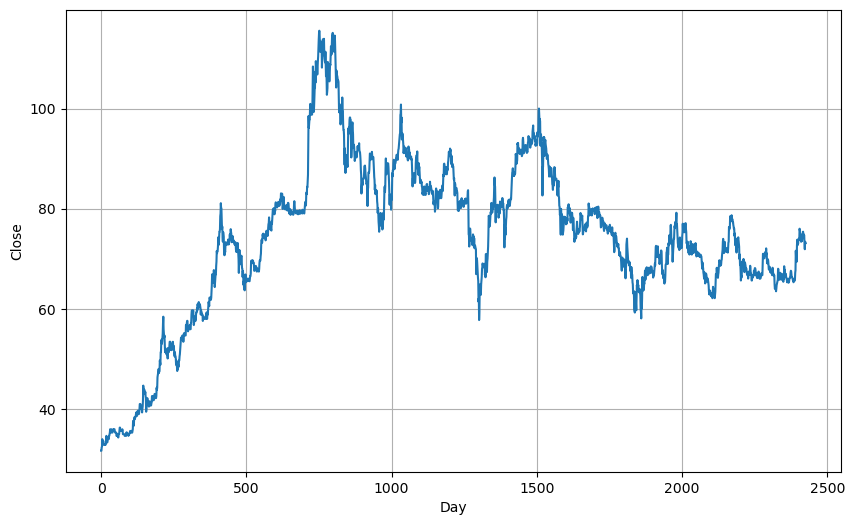

In [4]:
# Initialize lists
time_step = []
close = []

# Open CSV file
with open('D:\DeTaiNam2024\SoLieuHong\VNM.csv') as csvfile:
  
  # Initialize reader
  reader = csv.reader(csvfile, delimiter=',')
  
  # Skip the first line
  next(reader)
  
  # Append row and sunspot number to lists
  for row in reader:
    time_step.append(int(row[0]))
    close.append(float(row[5]))

# Convert lists to numpy arrays
time_step = np.array(time_step)
series = np.array(close)

# Preview the data
plot_series(time_step, series, xlabel='Day', ylabel='Close')

In [5]:
# Define the split time
split_time = 2000

# Get the train set 
time_train = time_step[:split_time]
x_train = series[:split_time]

# Get the validation set
time_valid = time_step[split_time:]
x_valid = series[split_time:]
# Parameters
window_size = 30
batch_size = 32
shuffle_buffer_size = 500
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    """Generates dataset windows

    Args:
      series (array of float) - contains the values of the time series
      window_size (int) - the number of time steps to include in the feature
      batch_size (int) - the batch size
      shuffle_buffer(int) - buffer size to use for the shuffle method

    Returns:
      dataset (TF Dataset) - TF Dataset containing time windows
    """
  
    # Generate a TF Dataset from the series values
    dataset = tf.data.Dataset.from_tensor_slices(series)
    
    # Window the data but only take those with the specified size
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    
    # Flatten the windows by putting its elements in a single batch
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))

    # Create tuples with features and labels 
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))

    # Shuffle the windows
    dataset = dataset.shuffle(shuffle_buffer)
    
    # Create batches of windows
    dataset = dataset.batch(batch_size).prefetch(1)
    
    return dataset
# Generate the dataset windows
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

In [6]:
import time
start_time = time.time()
# Build the model
model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[window_size]),
  tf.keras.layers.SimpleRNN(40, return_sequences=True),
  tf.keras.layers.SimpleRNN(40),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 100.0)
])

# Set the learning rate
learning_rate = 1e-6

# Set the optimizer 
optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)

# Set the training parameters
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

# Train the model
history = model.fit(dataset,epochs=100)
end_time = time.time()
train_time_cls = end_time - start_time
print(f'Thời gian huấn luyện mô hình DNN: {train_time_cls:.4f} giây')

Epoch 1/100
62/62 [==============================] - 20s 139ms/step - loss: 12.2967 - mae: 12.7866
Epoch 2/100
62/62 [==============================] - 1s 20ms/step - loss: 12.4269 - mae: 12.9156
Epoch 3/100
62/62 [==============================] - 2s 24ms/step - loss: 9.9516 - mae: 10.4371
Epoch 4/100
62/62 [==============================] - 1s 21ms/step - loss: 9.4417 - mae: 9.9282
Epoch 5/100
62/62 [==============================] - 1s 19ms/step - loss: 9.8925 - mae: 10.3784
Epoch 6/100
62/62 [==============================] - 1s 13ms/step - loss: 8.5191 - mae: 9.0043
Epoch 7/100
62/62 [==============================] - 1s 16ms/step - loss: 8.4071 - mae: 8.8929
Epoch 8/100
62/62 [==============================] - 1s 18ms/step - loss: 6.5858 - mae: 7.0656
Epoch 9/100
62/62 [==============================] - 1s 13ms/step - loss: 5.8932 - mae: 6.3737
Epoch 10/100
62/62 [==============================] - 1s 13ms/step - loss: 4.9760 - mae: 5.4564
Epoch 11/100
62/62 [=====================

62/62 [==============================] - 1s 13ms/step - loss: 1.7932 - mae: 2.2457
Epoch 87/100
62/62 [==============================] - 1s 14ms/step - loss: 1.3761 - mae: 1.8149
Epoch 88/100
62/62 [==============================] - 1s 13ms/step - loss: 2.9722 - mae: 3.4363
Epoch 89/100
62/62 [==============================] - 1s 13ms/step - loss: 1.9199 - mae: 2.3819
Epoch 90/100
62/62 [==============================] - 1s 13ms/step - loss: 1.7484 - mae: 2.1982
Epoch 91/100
62/62 [==============================] - 1s 14ms/step - loss: 2.0244 - mae: 2.4827
Epoch 92/100
62/62 [==============================] - 1s 16ms/step - loss: 1.1496 - mae: 1.5776
Epoch 93/100
62/62 [==============================] - 1s 16ms/step - loss: 2.4945 - mae: 2.9538
Epoch 94/100
62/62 [==============================] - 1s 18ms/step - loss: 1.6350 - mae: 2.0777
Epoch 95/100
62/62 [==============================] - 1s 14ms/step - loss: 1.9293 - mae: 2.3852
Epoch 96/100
62/62 [==============================] -

In [7]:
def model_forecast(model, series, window_size, batch_size):
    """Uses an input model to generate predictions on data windows

    Args:
      model (TF Keras Model) - model that accepts data windows
      series (array of float) - contains the values of the time series
      window_size (int) - the number of time steps to include in the window
      batch_size (int) - the batch size

    Returns:
      forecast (numpy array) - array containing predictions
    """

    # Generate a TF Dataset from the series values
    dataset = tf.data.Dataset.from_tensor_slices(series)

    # Window the data but only take those with the specified size
    dataset = dataset.window(window_size, shift=1, drop_remainder=True)

    # Flatten the windows by putting its elements in a single batch
    dataset = dataset.flat_map(lambda w: w.batch(window_size))
    
    # Create batches of windows
    dataset = dataset.batch(batch_size).prefetch(1)
    
    # Get predictions on the entire dataset
    forecast = model.predict(dataset)
    
    return forecast

14/14 [==============================] - 1s 11ms/step


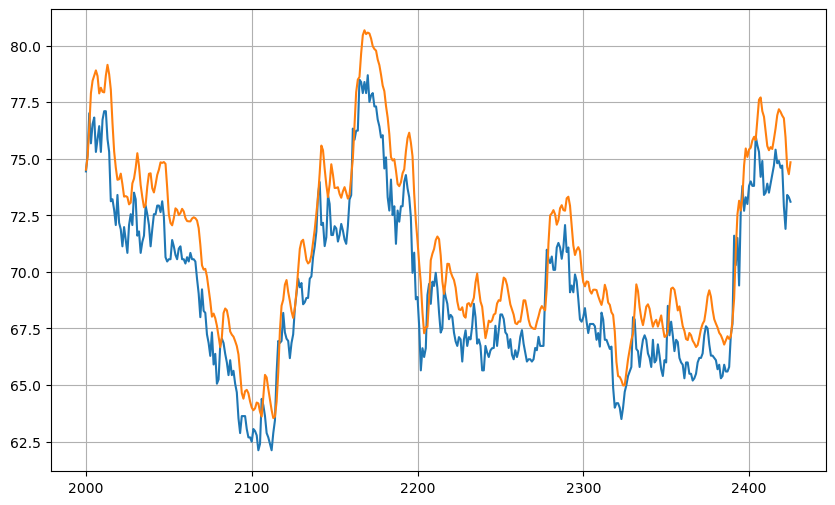

[74.516624 75.07991  76.39725  77.89681  78.44637  78.67897  78.90278
 78.651024 77.884224 78.136185 77.9566   77.93068  78.670586 79.14738
 78.73412  78.05379  76.58451  75.3285   74.610565 74.069305 74.09479
 74.34185  73.87611  73.325386 73.34888  73.3044   72.9848   73.05918
 73.91057  74.12382  74.59474  75.243416 74.681335 73.83729  73.30321
 72.8552   72.962105 73.769226 74.33477  74.3565   73.6986   73.510895
 73.86696  74.285866 74.51504  74.8407   74.815025 74.85353  74.7732
 73.72382  72.54601  72.161095 72.05826  72.369156 72.80859  72.74027
 72.51129  72.60227  72.78578  72.67041  72.38129  72.247025 72.235016
 72.23243  72.359505 72.41201  72.37328  72.27076  71.93562  71.196884
 70.291176 70.09913  70.13659  69.79493  69.23354  68.69993  68.0218
 68.1593   67.95559  67.62156  67.13885  66.674484 67.129234 68.18181
 68.382965 68.304016 67.92557  67.36856  67.22672  67.13862  66.944214
 66.725296 66.353874 65.543015 64.650314 64.40037  64.73162  64.789894
 64.63737  64.277

In [8]:
# Reduce the original series
forecast_series = series[split_time-window_size:-1]

# Use helper function to generate predictions
forecast = model_forecast(model, forecast_series, window_size, batch_size)

# Drop single dimensional axis
results = forecast.squeeze()

# Plot the results
plot_series(time_valid, (x_valid, results))
print(results)
# Giả sử x_valid và results là các mảng dự đoán và giá trị thực
x_valid = np.array(x_valid)
results = np.array(results)

# Tính Mean Squared Error
mse = tf.keras.metrics.mean_squared_error(x_valid, results).numpy()
print("MSE:", mse)

# Tính Mean Absolute Percentage Error (MAPE)
non_zero_indices = x_valid != 0  # Đảm bảo không có giá trị 0 trong mẫu
mean_error_percent = np.mean(np.abs((x_valid[non_zero_indices] - results[non_zero_indices]) / x_valid[non_zero_indices]))
accuracy = 1 - mean_error_percent  # Tính accuracy từ MAPE

print("Mean Error Percent:", mean_error_percent)
print("Accuracy:", accuracy)